In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from tensorflow import keras

In [3]:
import re

def to_float_str(element):
    try:
        return str(float(element))
    except ValueError:
        return element



def get_dataset(target):
    targets = pd.read_csv(f'kdd/{target}.labels', names=['target'])['target']
    targets = targets.apply(lambda x: 1 if x == 1 else 0)
    data = pd.read_csv('kdd/kdd.data', sep='\t')
    data[target] = targets
    targets = data[target]
    data.drop([target], axis=1, inplace=True)
    
    categorical_features = {
        190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 209,
        210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228,
    }

    for i in categorical_features:
        data[data.columns[i]].fillna("?", inplace=True)
        data[data.columns[i]] = data[data.columns[i]].apply(lambda x: to_float_str(x))


    columns_to_impute = []
    for i, column in enumerate(data.columns):
        if i not in categorical_features and pd.isnull(data[column]).any():
            columns_to_impute.append(column)
    for column_name in columns_to_impute:
        data[column_name + "_imputed"] = pd.isnull(data[column_name]).astype(float)
        data[column_name].fillna(0, inplace=True)

    return data, targets, [data.columns[x] for x in categorical_features]



BEST NETWORK PARAMETERS:
((160, 160, 160, 64), 'relu', 0.2, 'adam'): auc=0.792, acc=0.982
((160, 160, 64), 'relu', 0.35, 'adam'): auc=0.790, acc=0.982
((160, 128), 'relu', 0.2, 'adam'): auc=0.789, acc=0.983
((128, 128, 32), 'relu', 0.35, 'adam'): auc=0.788, acc=0.983
((160, 160, 128), 'relu', 0.2, 'adam'): auc=0.788, acc=0.981


Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


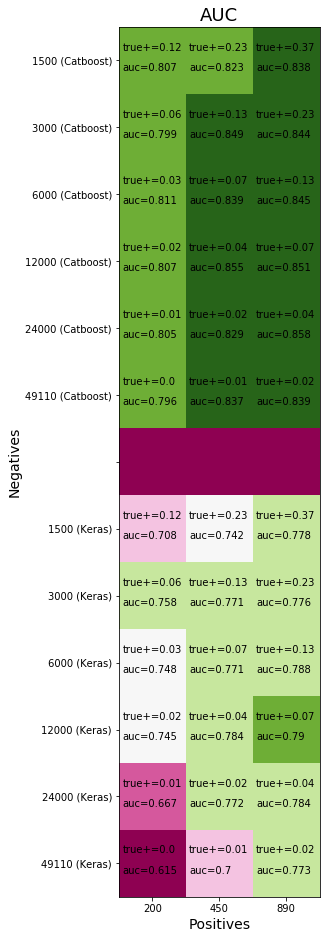

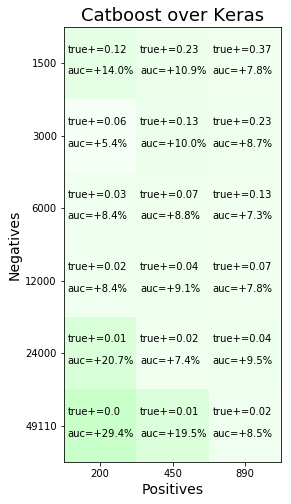

---- METRICS SUMMARY ----
  accuracy: catboost=0.982 (-0.02%), keras=0.983 (+0.02%)

      loss: catboost=0.073 (-12.40%), keras=0.083 (+14.16%)

   roc_auc: catboost=0.839 (+8.49%), keras=0.773 (-7.83%)

-------------------------


In [4]:
from base_experiment import BaseExperiment

class AppetencyExperiment(BaseExperiment):
    POSITIVE_STEPS =[200, 450, 890]
    NEGATIVE_STEPS = [1500, 3000, 6000, 12000, 24000, 49110]
    PLOT_FIG_SIZE = (12, 16)

    def get_dataset(self):
        return get_dataset('appetency')
    
    
AppetencyExperiment().run()


BEST NETWORK PARAMETERS:
((128, 64), 'tanh', 0.2, 'adam'): auc=0.798, acc=0.927
((128, 160, 64, 32), 'tanh', 0.2, 'adam'): auc=0.797, acc=0.930
((160, 160, 128), 'tanh', 0.35, 'adam'): auc=0.796, acc=0.927
((128, 128, 64), 'tanh', 0.2, 'adam'): auc=0.795, acc=0.927
((128, 128, 128, 64), 'relu', 0.2, 'adam'): auc=0.795, acc=0.927


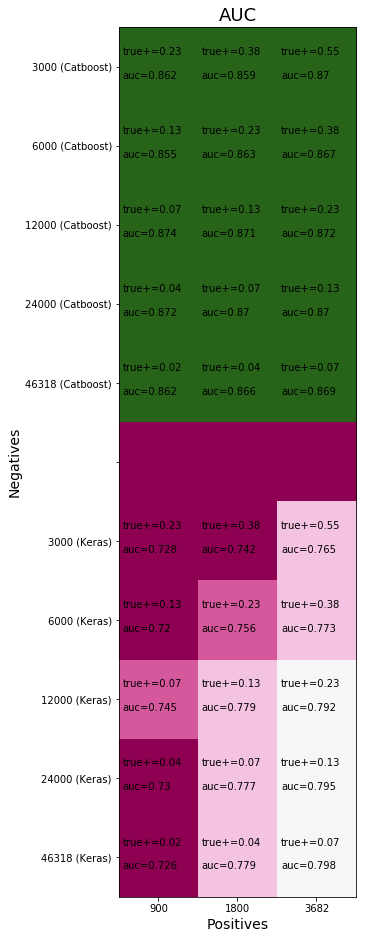

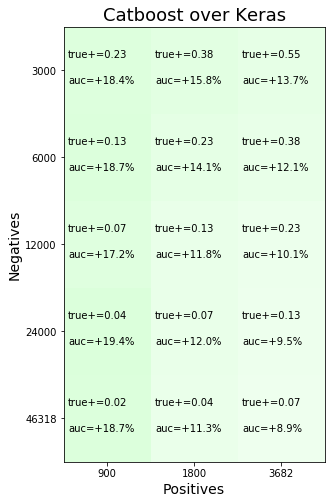

---- METRICS SUMMARY ----
  accuracy: catboost=0.950 (+2.09%), keras=0.931 (-2.04%)

      loss: catboost=0.168 (-23.12%), keras=0.218 (+30.07%)

   roc_auc: catboost=0.869 (+8.87%), keras=0.798 (-8.15%)

-------------------------


In [5]:
from base_experiment import BaseExperiment

class UpsellingExperiment(BaseExperiment):
    POSITIVE_STEPS = [900, 1800, 3682]
    NEGATIVE_STEPS = [3000, 6000, 12000, 24000, 46318]
    PLOT_FIG_SIZE = (12, 16)

    def get_dataset(self):
        return get_dataset('upselling')
    
    
UpsellingExperiment().run()